# Data 확인 및 결측값 채우기

In [1]:
from modules.local_values import tickers, raw_datas, datas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 결측값 채우기
volume, value => 0  
실제 거래가 없는 경우는 0  
서버 오류 등 결측값의 경우 결측값을 알림  
  
그 외 가격들은 전부 interpolate로 보간  

In [2]:
for raw_file,tick in zip(raw_datas,tickers):
    df=pd.read_csv(raw_file,parse_dates=[0],index_col=[0])
    df=df.resample(rule='T').first()
    df[['volume','value']]=df[['volume','value']].fillna(0)
    df=df.interpolate()
    msg='Data{:>9}\tTotal:{:>8}\tNaN:{:2}' \
        .format(tick,len(df),df['open'].isnull().sum())
    print(msg)

Data  KRW-BTC	Total: 3212988	NaN: 0
Data  KRW-ETH	Total: 3214676	NaN: 0
Data  KRW-XRP	Total: 3216739	NaN: 0
Data  KRW-SOL	Total: 1085282	NaN: 0
Data KRW-AVAX	Total:  918362	NaN: 0
Data KRW-DOGE	Total: 1421425	NaN: 0
Data  KRW-ETC	Total: 3218052	NaN: 0


## 데이터 전처리
#### 예측에 필요한 정보가 과연 무엇인가  

|주기|추세|불규칙|휴먼이슈|
|:--:|:--:|:--:|:------:|
|계절, 순환, 24시|단기/장기 성장률|뉴스,검색량,트위터|가격 상한선, 예약 매매|
  
주기 > 영향이 적을 것이라 생각  
추세 > 물타기, 가장 영향이 클 것으로 생각  
불규칙 > 추후에 추가  
휴먼 이슈 > 딱 떨어지는 가격, 목표 이율  

### 거래량 주기 파악
각 해의 누적 거래량을 파악한다.  
거래가 활발히 이루어지는 날이 따로 있는지 확인한다.  
  
금액에 따라 거래량이 달라지므로, 종가를 곱해준다. 

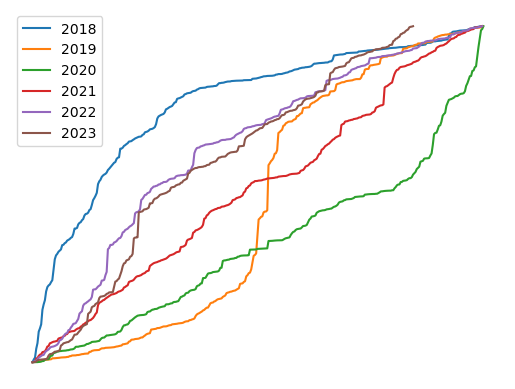

In [3]:
df=pd.read_csv(raw_datas[0],parse_dates=[0],index_col=[0])
df=df['close']*df['volume']
df=df.resample(rule='D').first()
for i in range(2018,2024):
    df_temp=df.loc[str(i)]
    df_temp=df_temp.reset_index(drop=True).cumsum()
    df_temp=df_temp-df_temp.min()
    df_temp=df_temp/df_temp.max()
    plt.plot(df_temp,label=str(i))
plt.axis('off')
plt.legend()
plt.show()

해마다 주기적으로 거래량의 변화가 나타나지는 않는다.  
다만 한번 상승할 때에 많이 상승하는 것을 알 수 있다.  => 추세

## 주가 지표
주가 분석에서 사용되는 지표들을 사용하여 분석해본다. 
|RSI|BB/BP|MACD|dis|Mmt|EMA|
|---|-----|----|---|---|---|
|상대 강도지수|볼린저밴드|추세지표|이격도|모멘텀|지수 이동평균|

In [6]:
import modules.indicators as idc
df=pd.read_csv(raw_datas[0],parse_dates=[0],index_col=[0])[:400]
df['RSI'] = idc.RSI(df,14).values / 100
(df['BB'],df['BP']), (_) = idc.BB(df,20)
df['MACD'], _ = idc.MACD(df)
df['dis'] = idc.disparity(df, 20)
df['Mmt'] = idc.Mmt(df,20)
df['EMA5'] = idc.EMA(df,5)
df['EMA30'] = idc.EMA(df,30)
df['EMA60'] = idc.EMA(df,60)

### 지수 이동 평균
러프한 값으로 지표를 표현한다. 

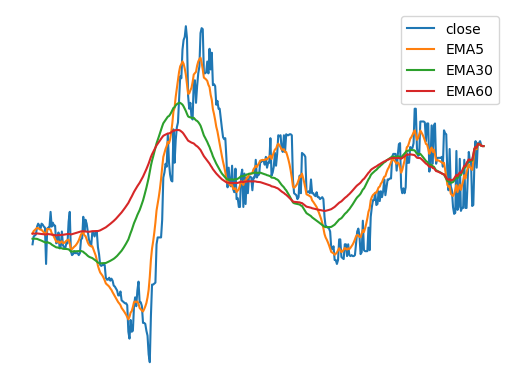

In [7]:
for ema in ['close','EMA5','EMA30','EMA60']:
    plt.plot(df[ema],label=ema)
plt.axis('off')
plt.legend()
plt.show()

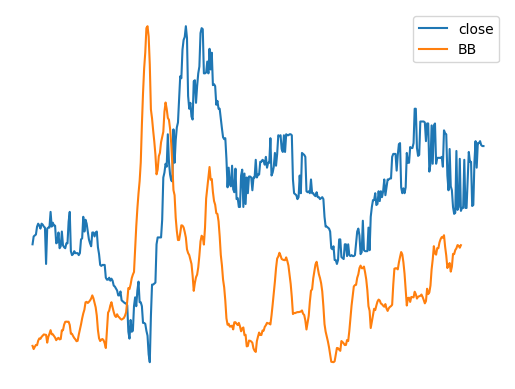

In [8]:
for bp in ['close','BB']:
    plt.plot(idc.MinMaxN(df[bp]),label=bp)
plt.axis('off')
plt.legend()
plt.show()

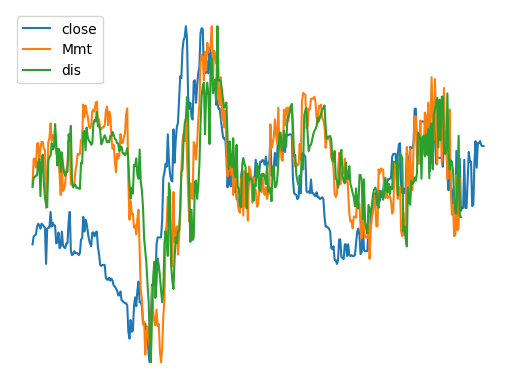

In [10]:
for bp in ['close','Mmt','dis']:
    plt.plot(idc.MinMaxN(df[bp]),label=bp)
plt.axis('off')
plt.legend()
plt.show()

## 데이터 표준화
MinMax, Std, Robust

In [ ]:
df['diff']=df.index.to_series().diff().dt.total_seconds()/60

In [ ]:
df['diff'].map(lambda i : i+1).sum()

-37988.0

In [ ]:
df.describe()

,open,high,low,close,volume,value,RSI,diff
count,3.175000e+06,3.175000e+06,3.175000e+06,3.175000e+06,3.175000e+06,3.175000e+06,3.174987e+06,3.174999e+06
mean,2.567209e+07,2.568604e+07,2.565800e+07,2.567199e+07,5.799638e+00,1.490759e+08,4.985856e-01,-1.011965e+00
std,1.950767e+07,1.951835e+07,1.949693e+07,1.950756e+07,1.097979e+01,3.181951e+08,1.089325e-01,7.660165e-01
min,3.565000e+06,3.568000e+06,3.562000e+06,3.565000e+06,1.000000e-08,3.831000e-02,4.834642e-02,-4.760000e+02
25%,9.383000e+06,9.389000e+06,9.377000e+06,9.383000e+06,9.571221e-01,1.413939e+07,4.261722e-01,-1.000000e+00
50%,1.930100e+07,1.933000e+07,1.927700e+07,1.930150e+07,2.543780e+00,4.844383e+07,4.993911e-01,-1.000000e+00
75%,3.854800e+07,3.856600e+07,3.852700e+07,3.854700e+07,6.122392e+00,1.515788e+08,5.719499e-01,-1.000000e+00
max,8.269000e+07,8.270000e+07,8.261900e+07,8.269900e+07,7.188566e+02,2.516663e+10,9.870146e-01,-1.000000e+00
